**NEXT THINGS TO DO**


1.   NLTK zum Cleanen der Titel
2.   Custom Accuracy Score
3.   Bullet Points mit einbeziehen
4.   Image Features mit einbeziehen





In [66]:
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
from skimage.transform import resize
from PIL import Image
from io import BytesIO
import tensorflow as tf
import tensorflow_hub as hub
import statistics
import matplotlib.pyplot as plt;
from google.colab import files
from sklearn import metrics
import seaborn as sb

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
#Der Header funkt
HEADERS = {'User-Agent':
            'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36',
            'Accept-Language': 'en-US, en;q=0.5'}

2 Verschiedene "Modi":
- 1  Automatisches Erstellen der Listen anhand von Keyword und Referenzprodukt
- 2 Bearbeitung (Score assessment) existierender CSVs

In [47]:
Modi=2 #1 oder 2
#Path_CSV=r"/content/contrastive_dataset.csv"

In [48]:
#1:
def Get_items(soups):
  urls=[]
  Titles=[]
  ASINs=[]
  for soup in soups:
      for Prod_q in soup.select("a.a-link-normal.a-text-normal"):
          Prod=Prod_q.select('span.a-size-base-plus.a-color-base.a-text-normal')
          if Prod!=[]:
              Titles.append(Prod[0].get_text())
              hreff=re.search("(?<=dp).*", Prod_q.find_parent().find(name="a")["href"]).group(0)
              if hreff[0]=="%":
                  ASINs.append(hreff.split("%")[1][2:])
              else:
                  ASINs.append(hreff.split("/")[1])
  return Titles, ASINs
if Modi==1:
    #Keyword (Manuell)
    Keywords=["Haarschere"]
    #Titel des Ref. Produkts (Manuell)
    Ref_Prod="Haarschere Premium Friseurscheren, Lidasen Scharfe Licht Ausdünnen Haarschneideschere, Edelstahl Friseurschere Profi Frisörschere mit Etui, Perfekter Effilierschere für Damen und Herren"
    #Soups der Result pages
    Result_soups = [BeautifulSoup(requests.get("https://www.amazon.de/s?k="+keyw.replace(" ", "+"), headers=HEADERS).text, "html5lib") for keyw in Keywords]
    #Gibt Listen der ASINs und Titel der Produkte wieder
      
  #Listen der Titel und ASINs 
    Titles, ASINs=Get_items(Result_soups)
#2:
elif Modi==2:
    #uploaded = files.upload()
    Dataset=pd.read_csv("/content/drive/MyDrive/contrastive_dataset.csv", index_col="ASIN")
    ASINs=list(Dataset.index)
    Titles=list(Dataset.Title)
    Ref_Prod=list(Dataset[Dataset.Comment=="Referenz"].Title)[0]
urls=["https://www.amazon.de/dp/"+ ASIN for ASIN in ASINs]

In [49]:
#Provisorische Blacklist. Elemente aus dieser Liste werden aus den Titeln entfernt.
Clean_Prov=[",", "/", "(", ")", "|", ".", "-"]

#Entfernt Strings die in "Clean_prov" enthalten sind aus den Titeln
#Und Gibt Listen der übrigen Wörter wieder: [["Titel(,) Test"], ["Test|2"]] -> [["Titel", "Test"], ["Test", "2"]]
def Clean_WordLister(Title, Clean=Clean_Prov):
    for elem in Clean:
        Title=Title.replace(elem, "")
    #return list(dict.fromkeys(Title.lower().split(" ")))
    return list(filter(None, list(dict.fromkeys(Title.lower().split(" ")))))
#S.o.
def Clean_SentenceLister(Title, Clean=Clean_Prov):
  for elem in Clean:
    Title=Title.replace(elem, "")
  return Title.lower()
#Wendet Clean_wordlister auf den Referenztitel und die Vergleichstitel
#der Results an und speichert diese Listen in Clean_ref_W & Clean_Titles_W
Clean_Ref_W=Clean_WordLister(Ref_Prod)
Clean_Titles_W=[]
for elem in Titles:
  Title=Clean_WordLister(elem)
  Clean_Titles_W.append(Title)

Clean_Ref_S=Clean_SentenceLister(Ref_Prod)
Clean_Titles_S=[]
for elem in Titles:
  Title=Clean_SentenceLister(elem)
  Clean_Titles_S.append(Title)
#Für jedes Wort im Titel des Referenzprodukts das im zum vergleichenden Produkttitel vorkommt
#+1 Score, Geteilt durch die Anzahl der Wörter, d.h. max. Score = 1
def Assess_products(titles=Clean_Titles_W, ref=Clean_Ref_W):
    Scores=np.zeros((len(titles)))
    for elem in ref:
        for i in range(len(titles)):
            for j in range(len(titles[i])):
                if elem==titles[i][j]:
                    Scores[i]+=1
    return [Scores[i]/len(titles[i]) for i in range(len(titles))]
Dataset["EasyScore"]=Assess_products()

In [50]:
#Produktbilder
Session = requests.Session()
Session.headers.update({
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_3) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.0.5 Safari/605.1.15"
})
def get_product_image(ASINs, session=Session):
    response = session.get(f"https://www.amazon.de/dp/{ASINs}")
    soup = BeautifulSoup(response.text, "html.parser")
    image_url = soup.find("div", {"id": "imgTagWrapperId"}).find("img").get("data-old-hires")
    image = Image.open(BytesIO(requests.get(image_url).content))
    image = np.array(image)
    return resize(image, (256, 256, 3))
#Embedding Model
embedding = hub.KerasLayer(
    "https://tfhub.dev/google/nnlm-de-dim128-with-normalization/2", 
    input_shape=[],
    dtype=tf.string)

In [51]:
#Bildung der Wortvektoren anhand der Clean_Titles_W
#Embeddings werden in einem Dictionary gespeichert und falls existent wird
#Dieses abgerufen anstatt embedding nochmal zu callen.
def Embedd_Titles_W(Title_List=Clean_Titles_W):
    Embeddeds={}
    Ordered_Emb=[]
    for i in range(len(Title_List)):
        Ordered_Emb.append([])
        for j in Title_List[i]:
          if j not in Embeddeds.keys():
            Embeddeds[j]=embedding([j])
          Ordered_Emb[i].append(Embeddeds[j])
    return Ordered_Emb
Emb_W=Embedd_Titles_W()
Clean_Ref_Emb_W=Embedd_Titles_W(Clean_Ref_W)
#Bildung der Satzvektoren anhand der Clean_Titles_S
def Embedd_Titles_S(Titles=Clean_Titles_S):
  return [embedding([i]) for i in Titles]
Emb_S=Embedd_Titles_S()
Clean_Ref_Emb_S=Embedd_Titles_S([Clean_Ref_S])
#Verschiedene Metriken der Vektoren
def Euclid(Embedd1, Embedd2):
    return np.linalg.norm(Embedd1-Embedd2)
def Manhattan(Embedd1, Embedd2):
    return np.sum(np.abs(Embedd1-Embedd2))
def Maximums(Embedd1, Embedd2):
    return np.max(np.abs(Embedd1-Embedd2))
def Cos_Sim(Embedd1, Embedd2):
    a_normalized = tf.nn.l2_normalize(Embedd1, axis=-1)
    b_normalized = tf.nn.l2_normalize(Embedd2, axis=-1)
    similarity = np.sum(tf.reduce_sum(tf.multiply(a_normalized, b_normalized), axis=-1))
    return similarity
def Vec_Score_W(Ordered_Emb=Emb_W, Clean_Ref=Clean_Ref_Emb_W):
    Scores_Euclid=[]
    Scores_Manhattan=[]
    Scores_Maximums=[]
    Scores_Cos=[]
    for emb in Ordered_Emb:
        Temp_Scores=[[],[],[],[]]
        for elem in emb:
          for ref in Clean_Ref:
              Temp_Scores[0].append(Euclid(elem, ref))
              Temp_Scores[1].append(Manhattan(elem, ref))
              Temp_Scores[2].append(Maximums(elem, ref))
              Temp_Scores[3].append(Cos_Sim(elem, ref))
        Scores_Euclid.append(np.sum(Temp_Scores[0])/len(emb))
        Scores_Manhattan.append(np.sum(Temp_Scores[1])/len(emb))
        Scores_Maximums.append(np.sum(Temp_Scores[2])/len(emb))
        Scores_Cos.append(np.sum(Temp_Scores[3])/len(emb))
    return Scores_Euclid, Scores_Manhattan, Scores_Maximums, Scores_Cos
def Vec_Score_S(Ordered_Emb=Emb_S, Clean_Ref=Clean_Ref_Emb_S):
    Scores_Euclid=[]
    Scores_Manhattan=[]
    Scores_Maximums=[]
    Scores_Cos=[]
    for elem in Ordered_Emb:
      Scores_Euclid.append(Euclid(elem, Clean_Ref))
      Scores_Manhattan.append(Manhattan(elem, Clean_Ref))
      Scores_Maximums.append(Maximums(elem, Clean_Ref))
      Scores_Cos.append(Cos_Sim(elem, Clean_Ref))
    return Scores_Euclid, Scores_Manhattan, Scores_Maximums, Scores_Cos

In [52]:
Euc_W, Man_W, Maxi_W, Cos_W = Vec_Score_W()
Dataset["Euclid_W"]=(Euc_W-np.mean(Euc_W))*1/np.std(Euc_W)
Dataset["Manhattan_W"]=(Man_W-np.mean(Man_W))*1/np.std(Man_W)
Dataset["Max_W"]=(Maxi_W-np.mean(Maxi_W))*1/np.std(Maxi_W)
Dataset["Cos_W"]=(Cos_W-np.mean(Cos_W))*1/np.std(Cos_W)
Euc_S, Man_S, Maxi_S, Cos_S=Vec_Score_S()
Dataset["Euclid_S"]=(Euc_S-np.mean(Euc_S))*1/np.std(Euc_S)
Dataset["Manhattan_S"]=(Man_S-np.mean(Man_S))*1/np.std(Man_S)
Dataset["Max_S"]=(Maxi_S-np.mean(Maxi_S))*1/np.std(Maxi_S)
Dataset["Cos_S_"]=(Cos_S-np.mean(Cos_S))*1/np.std(Cos_S)

In [63]:
W_Scores=[Euc_W, Man_W, Maxi_W, Cos_W]
S_Scores=[Euc_S, Man_S, Maxi_S, Cos_S]

In [64]:
Accuracy_W=[]
for i in W_Scores:
  Accuracy_W.append(abs(Dataset["Product class"]-np.array(i)/np.max(i)))

In [65]:
Accuracy_S=[]
for i in S_Scores:
  Accuracy_S.append(abs(Dataset["Product class"]-np.array(i)/np.max(i)))

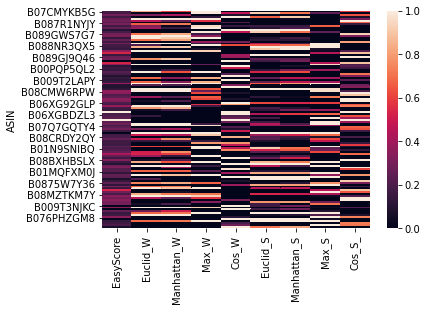

In [83]:
%matplotlib inline
sb.heatmap(Dataset.iloc[:, 6:], vmin=0, vmax=1)